## ⚠️ Before new utils.py version with ModelLifecycle

In [121]:
import torch
from torch import nn
import torch.nn.functional as F
import utils
from torchvision.models import resnet18, resnet50, ResNet18_Weights, ResNet50_Weights
from importlib import reload
reload(utils)

<module 'utils' from '/home/amitaharoni/workspace/cv-sprint/models/utils.py'>

In [5]:
train_dl, valid_dl, test_dl = utils.make_tiny_imagenet_dataloaders()
len(train_dl.dataset), len(valid_dl.dataset), len(test_dl.dataset)

(90000, 10000, 10000)

In [25]:
sample_batch, _ = next(iter(train_dl))
sample_img = sample_batch[:1]
sample_img.shape

torch.Size([1, 3, 64, 64])

In [98]:
def train(model, name, lr=1e-3, weight_decay=0):
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    hist = utils.train_model(model, train_dl, valid_dl, loss_fn, optimizer, epochs=1000, patience=4, tensorboard_dir=f'../runs/03-{name}', metrics=[utils.metric_accuracy])
    print(utils.evaluate_model(model, test_dl, loss_fn, metrics=[utils.metric_accuracy]))
    utils.plot_metrics(hist)

In [19]:
class ResNetSimpleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down_sampling=False):
        super().__init__()
        stride = 2 if down_sampling else 1
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=out_channels),
        )

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(num_features=out_channels)
            )

    def forward(self, x):
        skip = x
        output = self.layers(x)
        if self.downsample is not None:
            skip = self.downsample(skip) 
        output += skip
        output = F.relu(output, inplace=True)
        return output
        
ResNetSimpleBlock(3, 16, True)(sample_img).shape

torch.Size([1, 16, 32, 32])

In [26]:
class ResNet1(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            ResNetSimpleBlock(in_channels=64, out_channels=64, down_sampling=False),
            ResNetSimpleBlock(in_channels=64, out_channels=64, down_sampling=False),
            ResNetSimpleBlock(in_channels=64, out_channels=128, down_sampling=True),
            ResNetSimpleBlock(in_channels=128, out_channels=128, down_sampling=False),
            ResNetSimpleBlock(in_channels=128, out_channels=256, down_sampling=True),
            ResNetSimpleBlock(in_channels=256, out_channels=256, down_sampling=False),
            ResNetSimpleBlock(in_channels=256, out_channels=512, down_sampling=True),
            ResNetSimpleBlock(in_channels=512, out_channels=512, down_sampling=False),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(in_features=512, out_features=200)
        )


    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

ResNet1()(sample_img).shape

torch.Size([1, 200])

100%|██████████| 157/157 [00:02<00:00, 73.50it/s]


Epoch 1/1000: train_loss=4.4150, train_accuracy=0.0848, val_loss=4.1063, val_accuracy=0.1146
Saving params from epoch 1. Best loss: 4.1063


100%|██████████| 157/157 [00:02<00:00, 68.61it/s]


Epoch 2/1000: train_loss=3.5609, train_accuracy=0.1993, val_loss=3.4709, val_accuracy=0.2169
Saving params from epoch 2. Best loss: 3.4709


100%|██████████| 157/157 [00:02<00:00, 74.81it/s]


Epoch 3/1000: train_loss=3.1400, train_accuracy=0.2744, val_loss=3.3644, val_accuracy=0.2382
Saving params from epoch 3. Best loss: 3.3644


100%|██████████| 157/157 [00:02<00:00, 68.98it/s]


Epoch 4/1000: train_loss=2.7791, train_accuracy=0.3408, val_loss=3.2426, val_accuracy=0.2746
Saving params from epoch 4. Best loss: 3.2426


100%|██████████| 157/157 [00:02<00:00, 74.93it/s]


Epoch 5/1000: train_loss=2.4172, train_accuracy=0.4102, val_loss=3.0090, val_accuracy=0.3169
Saving params from epoch 5. Best loss: 3.0090


100%|██████████| 157/157 [00:02<00:00, 76.31it/s]


Epoch 6/1000: train_loss=2.0035, train_accuracy=0.4940, val_loss=3.0883, val_accuracy=0.3102


100%|██████████| 157/157 [00:02<00:00, 73.22it/s]


Epoch 7/1000: train_loss=1.5038, train_accuracy=0.6029, val_loss=3.4150, val_accuracy=0.3034


100%|██████████| 157/157 [00:02<00:00, 75.65it/s]


Epoch 8/1000: train_loss=0.9852, train_accuracy=0.7288, val_loss=3.6585, val_accuracy=0.3128


100%|██████████| 157/157 [00:02<00:00, 75.63it/s]

Epoch 9/1000: train_loss=0.5606, train_accuracy=0.8408, val_loss=4.0903, val_accuracy=0.3004
Loading model params from epoch 5


{'loss': 3.008120097351074, 'accuracy': 0.3133}


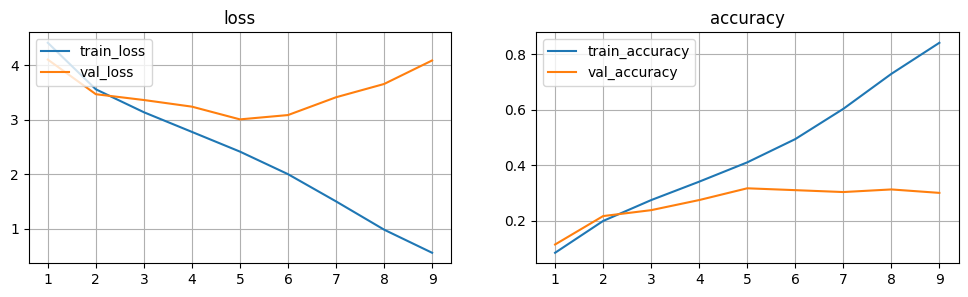

In [28]:
model1 = ResNet1().to(utils.device)
train(model1, 'resnet-01')

100%|██████████| 157/157 [00:02<00:00, 77.62it/s]


Epoch 1/1000: train_loss=4.4628, train_accuracy=0.0779, val_loss=5.0338, val_accuracy=0.0496
Saving params from epoch 1. Best loss: 5.0338


100%|██████████| 157/157 [00:02<00:00, 77.04it/s]


Epoch 2/1000: train_loss=3.6505, train_accuracy=0.1843, val_loss=3.8147, val_accuracy=0.1651
Saving params from epoch 2. Best loss: 3.8147


100%|██████████| 157/157 [00:02<00:00, 76.88it/s]


Epoch 3/1000: train_loss=3.2815, train_accuracy=0.2473, val_loss=3.5644, val_accuracy=0.2092
Saving params from epoch 3. Best loss: 3.5644


100%|██████████| 157/157 [00:02<00:00, 77.80it/s]


Epoch 4/1000: train_loss=2.9874, train_accuracy=0.3003, val_loss=3.2109, val_accuracy=0.2677
Saving params from epoch 4. Best loss: 3.2109


100%|██████████| 157/157 [00:02<00:00, 75.13it/s]


Epoch 5/1000: train_loss=2.7253, train_accuracy=0.3504, val_loss=3.0351, val_accuracy=0.3006
Saving params from epoch 5. Best loss: 3.0351


100%|██████████| 157/157 [00:02<00:00, 77.30it/s]


Epoch 6/1000: train_loss=2.4689, train_accuracy=0.3996, val_loss=3.3012, val_accuracy=0.2643


100%|██████████| 157/157 [00:02<00:00, 76.48it/s]


Epoch 7/1000: train_loss=2.2087, train_accuracy=0.4517, val_loss=3.3110, val_accuracy=0.2805


100%|██████████| 157/157 [00:02<00:00, 75.24it/s]


Epoch 8/1000: train_loss=1.9261, train_accuracy=0.5097, val_loss=3.0596, val_accuracy=0.3235


100%|██████████| 157/157 [00:02<00:00, 77.74it/s]


Epoch 9/1000: train_loss=1.6276, train_accuracy=0.5765, val_loss=3.4417, val_accuracy=0.2818
Loading model params from epoch 5
{'loss': 3.025372082901001, 'accuracy': 0.3073}


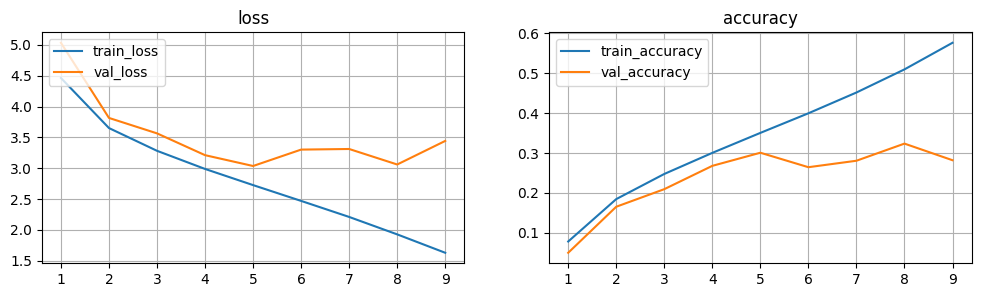

In [29]:
model2 = ResNet1().to(utils.device)
train(model2, 'resnet-02', weight_decay=1e-4)

100%|██████████| 157/157 [00:01<00:00, 89.84it/s] 


Epoch 1/1000: train_loss=4.7010, train_accuracy=0.0543, val_loss=4.9453, val_accuracy=0.0591
Saving params from epoch 1. Best loss: 4.9453


100%|██████████| 157/157 [00:01<00:00, 91.75it/s] 


Epoch 2/1000: train_loss=3.8045, train_accuracy=0.1621, val_loss=4.3228, val_accuracy=0.1084
Saving params from epoch 2. Best loss: 4.3228


100%|██████████| 157/157 [00:02<00:00, 74.55it/s]


Epoch 3/1000: train_loss=3.3780, train_accuracy=0.2306, val_loss=3.7801, val_accuracy=0.1846
Saving params from epoch 3. Best loss: 3.7801


100%|██████████| 157/157 [00:01<00:00, 89.81it/s] 


Epoch 4/1000: train_loss=3.0812, train_accuracy=0.2841, val_loss=3.6074, val_accuracy=0.2077
Saving params from epoch 4. Best loss: 3.6074


100%|██████████| 157/157 [00:01<00:00, 93.62it/s] 


Epoch 5/1000: train_loss=2.8197, train_accuracy=0.3316, val_loss=3.4028, val_accuracy=0.2409
Saving params from epoch 5. Best loss: 3.4028


100%|██████████| 157/157 [00:01<00:00, 96.07it/s] 


Epoch 6/1000: train_loss=2.5859, train_accuracy=0.3761, val_loss=3.6899, val_accuracy=0.2164


100%|██████████| 157/157 [00:01<00:00, 94.87it/s] 


Epoch 7/1000: train_loss=2.3575, train_accuracy=0.4214, val_loss=3.4520, val_accuracy=0.2471


100%|██████████| 157/157 [00:01<00:00, 96.17it/s] 


Epoch 8/1000: train_loss=2.1271, train_accuracy=0.4661, val_loss=3.7229, val_accuracy=0.2211


100%|██████████| 157/157 [00:01<00:00, 92.06it/s] 


Epoch 9/1000: train_loss=1.8977, train_accuracy=0.5129, val_loss=3.2007, val_accuracy=0.3032
Saving params from epoch 9. Best loss: 3.2007


100%|██████████| 157/157 [00:01<00:00, 91.81it/s] 


Epoch 10/1000: train_loss=1.6730, train_accuracy=0.5615, val_loss=3.5323, val_accuracy=0.2699


100%|██████████| 157/157 [00:01<00:00, 82.18it/s]


Epoch 11/1000: train_loss=1.4538, train_accuracy=0.6099, val_loss=3.6966, val_accuracy=0.2689


100%|██████████| 157/157 [00:01<00:00, 89.96it/s] 


Epoch 12/1000: train_loss=1.2613, train_accuracy=0.6537, val_loss=3.6667, val_accuracy=0.2745


100%|██████████| 157/157 [00:01<00:00, 86.67it/s]


Epoch 13/1000: train_loss=1.0812, train_accuracy=0.6980, val_loss=3.7916, val_accuracy=0.2809
Loading model params from epoch 9
{'loss': 3.1755367389678955, 'accuracy': 0.3018}


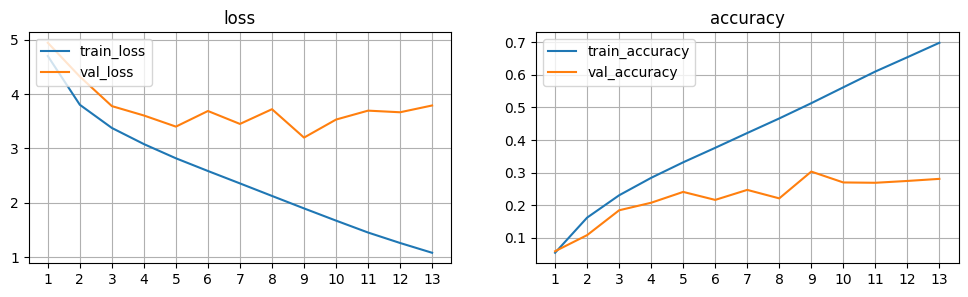

In [31]:
# Let's try SGD instead of Adam
model3 = ResNet1().to(utils.device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
hist = utils.train_model(model3, train_dl, valid_dl, loss_fn, optimizer, epochs=1000, patience=4, tensorboard_dir=f'../runs/03-resnet-03', metrics=[utils.metric_accuracy])
print(utils.evaluate_model(model3, test_dl, loss_fn, metrics=[utils.metric_accuracy]))
utils.plot_metrics(hist)

In [32]:
class ResNet2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            ResNetSimpleBlock(in_channels=64, out_channels=64, down_sampling=False),
            ResNetSimpleBlock(in_channels=64, out_channels=64, down_sampling=False),
            ResNetSimpleBlock(in_channels=64, out_channels=128, down_sampling=True),
            ResNetSimpleBlock(in_channels=128, out_channels=128, down_sampling=False),
            ResNetSimpleBlock(in_channels=128, out_channels=256, down_sampling=True),
            ResNetSimpleBlock(in_channels=256, out_channels=256, down_sampling=False),
            ResNetSimpleBlock(in_channels=256, out_channels=512, down_sampling=True),
            ResNetSimpleBlock(in_channels=512, out_channels=512, down_sampling=False),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features=200)
        )


    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

ResNet2()(sample_img).shape

torch.Size([1, 200])

100%|██████████| 157/157 [00:02<00:00, 75.11it/s]


Epoch 1/1000: train_loss=4.6820, train_accuracy=0.0545, val_loss=4.1559, val_accuracy=0.1142
Saving params from epoch 1. Best loss: 4.1559


100%|██████████| 157/157 [00:02<00:00, 75.53it/s]


Epoch 2/1000: train_loss=3.9352, train_accuracy=0.1397, val_loss=3.7674, val_accuracy=0.1712
Saving params from epoch 2. Best loss: 3.7674


100%|██████████| 157/157 [00:01<00:00, 91.41it/s] 


Epoch 3/1000: train_loss=3.6058, train_accuracy=0.1923, val_loss=3.7582, val_accuracy=0.1956
Saving params from epoch 3. Best loss: 3.7582


100%|██████████| 157/157 [00:01<00:00, 89.50it/s] 


Epoch 4/1000: train_loss=3.3707, train_accuracy=0.2335, val_loss=3.5164, val_accuracy=0.2260
Saving params from epoch 4. Best loss: 3.5164


100%|██████████| 157/157 [00:01<00:00, 90.10it/s] 


Epoch 5/1000: train_loss=3.1732, train_accuracy=0.2672, val_loss=3.2513, val_accuracy=0.2687
Saving params from epoch 5. Best loss: 3.2513


100%|██████████| 157/157 [00:01<00:00, 88.13it/s] 


Epoch 6/1000: train_loss=2.9884, train_accuracy=0.3002, val_loss=3.0880, val_accuracy=0.2936
Saving params from epoch 6. Best loss: 3.0880


100%|██████████| 157/157 [00:01<00:00, 91.76it/s] 


Epoch 7/1000: train_loss=2.8115, train_accuracy=0.3342, val_loss=2.9930, val_accuracy=0.3095
Saving params from epoch 7. Best loss: 2.9930


100%|██████████| 157/157 [00:01<00:00, 89.34it/s] 


Epoch 8/1000: train_loss=2.6500, train_accuracy=0.3629, val_loss=2.9376, val_accuracy=0.3179
Saving params from epoch 8. Best loss: 2.9376


100%|██████████| 157/157 [00:01<00:00, 89.17it/s] 


Epoch 9/1000: train_loss=2.4861, train_accuracy=0.3927, val_loss=2.9411, val_accuracy=0.3206


100%|██████████| 157/157 [00:01<00:00, 89.43it/s] 


Epoch 10/1000: train_loss=2.3182, train_accuracy=0.4254, val_loss=2.9306, val_accuracy=0.3250
Saving params from epoch 10. Best loss: 2.9306


100%|██████████| 157/157 [00:01<00:00, 87.00it/s] 


Epoch 11/1000: train_loss=2.1518, train_accuracy=0.4586, val_loss=3.1708, val_accuracy=0.2964


100%|██████████| 157/157 [00:01<00:00, 87.24it/s] 


Epoch 12/1000: train_loss=1.9961, train_accuracy=0.4884, val_loss=3.2511, val_accuracy=0.2884


100%|██████████| 157/157 [00:01<00:00, 88.70it/s] 


Epoch 13/1000: train_loss=1.8377, train_accuracy=0.5225, val_loss=3.1337, val_accuracy=0.3172


100%|██████████| 157/157 [00:01<00:00, 91.53it/s] 


Epoch 14/1000: train_loss=1.6937, train_accuracy=0.5492, val_loss=3.3319, val_accuracy=0.2928
Loading model params from epoch 10
{'loss': 2.9580351837158205, 'accuracy': 0.3205}


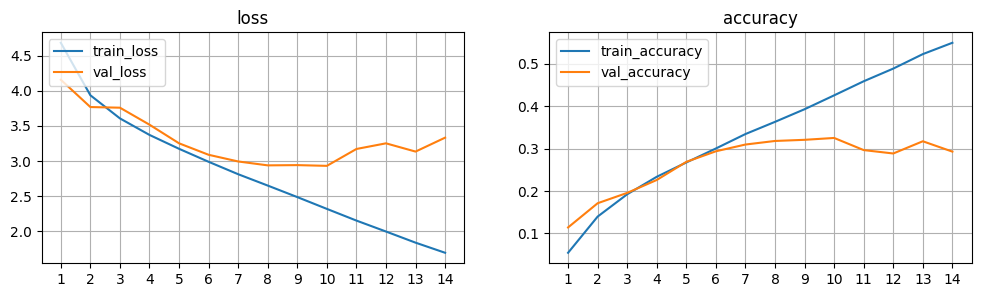

In [33]:
model4 = ResNet2().to(utils.device)
train(model4, 'resnet-04', weight_decay=1e-4)

In [34]:
train_dl, valid_dl, test_dl = utils.make_tiny_imagenet_dataloaders(batch_size=256)
len(train_dl.dataset), len(valid_dl.dataset), len(test_dl.dataset)

(90000, 10000, 10000)

100%|██████████| 40/40 [00:01<00:00, 24.76it/s]


Epoch 1/1000: train_loss=4.6527, train_accuracy=0.0591, val_loss=4.3615, val_accuracy=0.0940
Saving params from epoch 1. Best loss: 4.3615


100%|██████████| 40/40 [00:01<00:00, 33.41it/s]


Epoch 2/1000: train_loss=3.8752, train_accuracy=0.1483, val_loss=3.6882, val_accuracy=0.1723
Saving params from epoch 2. Best loss: 3.6882


100%|██████████| 40/40 [00:01<00:00, 36.01it/s]


Epoch 3/1000: train_loss=3.5250, train_accuracy=0.2026, val_loss=3.7200, val_accuracy=0.1799


100%|██████████| 40/40 [00:01<00:00, 24.65it/s]


Epoch 4/1000: train_loss=3.2821, train_accuracy=0.2437, val_loss=3.3181, val_accuracy=0.2362
Saving params from epoch 4. Best loss: 3.3181


100%|██████████| 40/40 [00:01<00:00, 27.40it/s]


Epoch 5/1000: train_loss=3.0663, train_accuracy=0.2814, val_loss=3.6608, val_accuracy=0.2069


100%|██████████| 40/40 [00:01<00:00, 34.52it/s]


Epoch 6/1000: train_loss=2.8678, train_accuracy=0.3198, val_loss=3.4476, val_accuracy=0.2370


100%|██████████| 40/40 [00:01<00:00, 33.88it/s]


Epoch 7/1000: train_loss=2.6764, train_accuracy=0.3552, val_loss=3.0476, val_accuracy=0.2973
Saving params from epoch 7. Best loss: 3.0476


100%|██████████| 40/40 [00:01<00:00, 33.91it/s]


Epoch 8/1000: train_loss=2.4612, train_accuracy=0.3974, val_loss=3.0185, val_accuracy=0.3061
Saving params from epoch 8. Best loss: 3.0185


100%|██████████| 40/40 [00:01<00:00, 32.54it/s]


Epoch 9/1000: train_loss=2.2466, train_accuracy=0.4371, val_loss=3.0366, val_accuracy=0.3139


100%|██████████| 40/40 [00:01<00:00, 34.97it/s]


Epoch 10/1000: train_loss=1.9986, train_accuracy=0.4871, val_loss=3.2561, val_accuracy=0.2938


100%|██████████| 40/40 [00:01<00:00, 35.39it/s]


Epoch 11/1000: train_loss=1.7388, train_accuracy=0.5428, val_loss=3.4003, val_accuracy=0.2775


100%|██████████| 40/40 [00:01<00:00, 32.95it/s]

Epoch 12/1000: train_loss=1.4774, train_accuracy=0.5988, val_loss=3.3587, val_accuracy=0.3033
Loading model params from epoch 8


{'loss': 3.030397849273682, 'accuracy': 0.303}


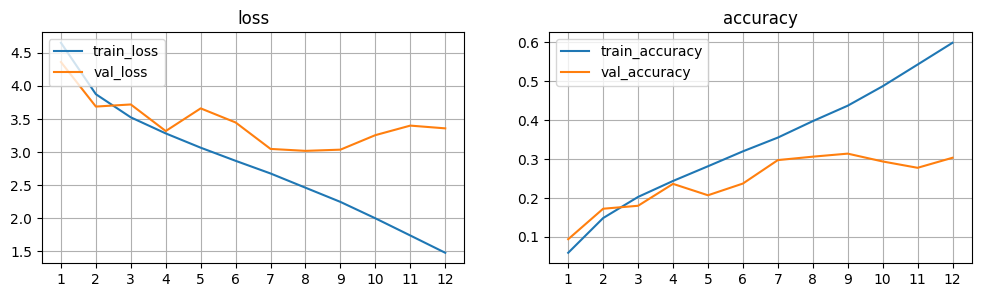

In [35]:
model5 = ResNet2().to(utils.device)
train(model5, 'resnet-05', weight_decay=1e-4)

In [38]:
train_dl, valid_dl, test_dl = utils.make_tiny_imagenet_dataloaders(batch_size=256, normalize=True)
len(train_dl.dataset), len(valid_dl.dataset), len(test_dl.dataset)

(90000, 10000, 10000)

100%|██████████| 40/40 [00:01<00:00, 32.26it/s]


Epoch 1/1000: train_loss=4.3560, train_accuracy=0.0957, val_loss=3.9576, val_accuracy=0.1400
Saving params from epoch 1. Best loss: 3.9576


100%|██████████| 40/40 [00:01<00:00, 25.59it/s]


Epoch 2/1000: train_loss=3.5204, train_accuracy=0.2076, val_loss=3.5308, val_accuracy=0.2096
Saving params from epoch 2. Best loss: 3.5308


100%|██████████| 40/40 [00:01<00:00, 31.14it/s]


Epoch 3/1000: train_loss=3.1107, train_accuracy=0.2779, val_loss=3.3275, val_accuracy=0.2484
Saving params from epoch 3. Best loss: 3.3275


100%|██████████| 40/40 [00:01<00:00, 31.35it/s]


Epoch 4/1000: train_loss=2.7637, train_accuracy=0.3413, val_loss=3.1595, val_accuracy=0.2791
Saving params from epoch 4. Best loss: 3.1595


100%|██████████| 40/40 [00:01<00:00, 32.03it/s]


Epoch 5/1000: train_loss=2.4345, train_accuracy=0.4052, val_loss=3.0171, val_accuracy=0.3099
Saving params from epoch 5. Best loss: 3.0171


100%|██████████| 40/40 [00:01<00:00, 29.37it/s]


Epoch 6/1000: train_loss=2.0656, train_accuracy=0.4776, val_loss=3.0529, val_accuracy=0.3193


100%|██████████| 40/40 [00:01<00:00, 30.88it/s]


Epoch 7/1000: train_loss=1.6400, train_accuracy=0.5711, val_loss=3.1984, val_accuracy=0.3124


100%|██████████| 40/40 [00:01<00:00, 29.97it/s]


Epoch 8/1000: train_loss=1.1531, train_accuracy=0.6870, val_loss=3.4901, val_accuracy=0.3075


100%|██████████| 40/40 [00:01<00:00, 29.95it/s]


Epoch 9/1000: train_loss=0.6661, train_accuracy=0.8155, val_loss=4.0018, val_accuracy=0.2885
Loading model params from epoch 5
{'loss': 3.0203938110351563, 'accuracy': 0.3078}


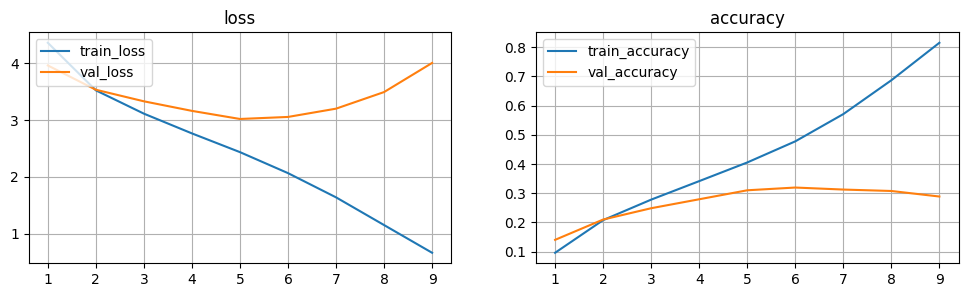

In [39]:
model6 = ResNet1().to(utils.device)
train(model6, 'resnet-06')

100%|██████████| 40/40 [00:01<00:00, 32.10it/s]


Epoch 1/1000: train_loss=4.6651, train_accuracy=0.0555, val_loss=4.1335, val_accuracy=0.1084
Saving params from epoch 1. Best loss: 4.1335


100%|██████████| 40/40 [00:01<00:00, 31.24it/s]


Epoch 2/1000: train_loss=3.8831, train_accuracy=0.1442, val_loss=3.7314, val_accuracy=0.1657
Saving params from epoch 2. Best loss: 3.7314


100%|██████████| 40/40 [00:01<00:00, 31.60it/s]


Epoch 3/1000: train_loss=3.5339, train_accuracy=0.1983, val_loss=3.4313, val_accuracy=0.2144
Saving params from epoch 3. Best loss: 3.4313


100%|██████████| 40/40 [00:01<00:00, 27.26it/s]


Epoch 4/1000: train_loss=3.2938, train_accuracy=0.2391, val_loss=3.3540, val_accuracy=0.2278
Saving params from epoch 4. Best loss: 3.3540


100%|██████████| 40/40 [00:01<00:00, 24.47it/s]


Epoch 5/1000: train_loss=3.0891, train_accuracy=0.2784, val_loss=3.2560, val_accuracy=0.2531
Saving params from epoch 5. Best loss: 3.2560


100%|██████████| 40/40 [00:01<00:00, 32.25it/s]


Epoch 6/1000: train_loss=2.8955, train_accuracy=0.3125, val_loss=3.0993, val_accuracy=0.2802
Saving params from epoch 6. Best loss: 3.0993


100%|██████████| 40/40 [00:01<00:00, 26.76it/s]


Epoch 7/1000: train_loss=2.6991, train_accuracy=0.3491, val_loss=3.1009, val_accuracy=0.2859


100%|██████████| 40/40 [00:01<00:00, 29.12it/s]


Epoch 8/1000: train_loss=2.4897, train_accuracy=0.3898, val_loss=3.0158, val_accuracy=0.3085
Saving params from epoch 8. Best loss: 3.0158


100%|██████████| 40/40 [00:01<00:00, 28.98it/s]


Epoch 9/1000: train_loss=2.2713, train_accuracy=0.4318, val_loss=3.0224, val_accuracy=0.3159


100%|██████████| 40/40 [00:01<00:00, 29.92it/s]


Epoch 10/1000: train_loss=2.0371, train_accuracy=0.4788, val_loss=3.1475, val_accuracy=0.3100


100%|██████████| 40/40 [00:01<00:00, 30.84it/s]


Epoch 11/1000: train_loss=1.7831, train_accuracy=0.5332, val_loss=3.2673, val_accuracy=0.3010


100%|██████████| 40/40 [00:01<00:00, 31.07it/s]

Epoch 12/1000: train_loss=1.5272, train_accuracy=0.5879, val_loss=3.3923, val_accuracy=0.3079
Loading model params from epoch 8


{'loss': 2.9891337394714355, 'accuracy': 0.3083}


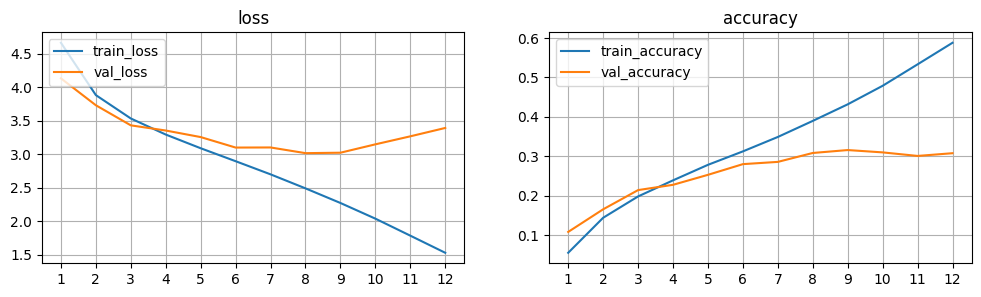

In [40]:
model7 = ResNet2().to(utils.device)
train(model7, 'resnet-07', weight_decay=1e-4)

In [4]:
train_dl, valid_dl, test_dl = utils.make_tiny_imagenet_dataloaders(batch_size=256, normalize=True, augment=True)
len(train_dl.dataset), len(valid_dl.dataset), len(test_dl.dataset)

(90000, 10000, 10000)

100%|██████████| 40/40 [00:01<00:00, 32.62it/s]


Epoch 1/1000: train_loss=4.7549, train_accuracy=0.0476, val_loss=4.3128, val_accuracy=0.0907
Saving params from epoch 1. Best loss: 4.3128


100%|██████████| 40/40 [00:01<00:00, 31.85it/s]


Epoch 2/1000: train_loss=4.0785, train_accuracy=0.1225, val_loss=3.8141, val_accuracy=0.1558
Saving params from epoch 2. Best loss: 3.8141


100%|██████████| 40/40 [00:01<00:00, 29.82it/s]


Epoch 3/1000: train_loss=3.7149, train_accuracy=0.1765, val_loss=3.5730, val_accuracy=0.1994
Saving params from epoch 3. Best loss: 3.5730


100%|██████████| 40/40 [00:01<00:00, 30.75it/s]


Epoch 4/1000: train_loss=3.4622, train_accuracy=0.2172, val_loss=3.3634, val_accuracy=0.2370
Saving params from epoch 4. Best loss: 3.3634


100%|██████████| 40/40 [00:01<00:00, 29.89it/s]


Epoch 5/1000: train_loss=3.2588, train_accuracy=0.2532, val_loss=3.1685, val_accuracy=0.2799
Saving params from epoch 5. Best loss: 3.1685


100%|██████████| 40/40 [00:01<00:00, 29.28it/s]


Epoch 6/1000: train_loss=3.0965, train_accuracy=0.2822, val_loss=3.1562, val_accuracy=0.2778
Saving params from epoch 6. Best loss: 3.1562


100%|██████████| 40/40 [00:01<00:00, 25.26it/s]


Epoch 7/1000: train_loss=2.9430, train_accuracy=0.3087, val_loss=3.0550, val_accuracy=0.2931
Saving params from epoch 7. Best loss: 3.0550


100%|██████████| 40/40 [00:01<00:00, 26.91it/s]


Epoch 8/1000: train_loss=2.8077, train_accuracy=0.3340, val_loss=2.8735, val_accuracy=0.3347
Saving params from epoch 8. Best loss: 2.8735


100%|██████████| 40/40 [00:01<00:00, 29.77it/s]


Epoch 9/1000: train_loss=2.6880, train_accuracy=0.3576, val_loss=2.8074, val_accuracy=0.3511
Saving params from epoch 9. Best loss: 2.8074


100%|██████████| 40/40 [00:01<00:00, 24.76it/s]


Epoch 10/1000: train_loss=2.5607, train_accuracy=0.3817, val_loss=2.7852, val_accuracy=0.3527
Saving params from epoch 10. Best loss: 2.7852


100%|██████████| 40/40 [00:01<00:00, 29.45it/s]


Epoch 11/1000: train_loss=2.4480, train_accuracy=0.4028, val_loss=2.8054, val_accuracy=0.3568


100%|██████████| 40/40 [00:01<00:00, 29.28it/s]


Epoch 12/1000: train_loss=2.3451, train_accuracy=0.4230, val_loss=2.6771, val_accuracy=0.3830
Saving params from epoch 12. Best loss: 2.6771


100%|██████████| 40/40 [00:01<00:00, 30.29it/s]


Epoch 13/1000: train_loss=2.2323, train_accuracy=0.4437, val_loss=2.6391, val_accuracy=0.3976
Saving params from epoch 13. Best loss: 2.6391


100%|██████████| 40/40 [00:01<00:00, 30.07it/s]


Epoch 14/1000: train_loss=2.1271, train_accuracy=0.4653, val_loss=2.6790, val_accuracy=0.3941


100%|██████████| 40/40 [00:01<00:00, 29.35it/s]


Epoch 15/1000: train_loss=2.0283, train_accuracy=0.4851, val_loss=2.7083, val_accuracy=0.3882


100%|██████████| 40/40 [00:01<00:00, 29.76it/s]


Epoch 16/1000: train_loss=1.9237, train_accuracy=0.5081, val_loss=2.7374, val_accuracy=0.3845


100%|██████████| 40/40 [00:01<00:00, 30.76it/s]


Epoch 17/1000: train_loss=1.8197, train_accuracy=0.5301, val_loss=2.6773, val_accuracy=0.4045
Loading model params from epoch 13
{'loss': 2.616875963592529, 'accuracy': 0.3892}


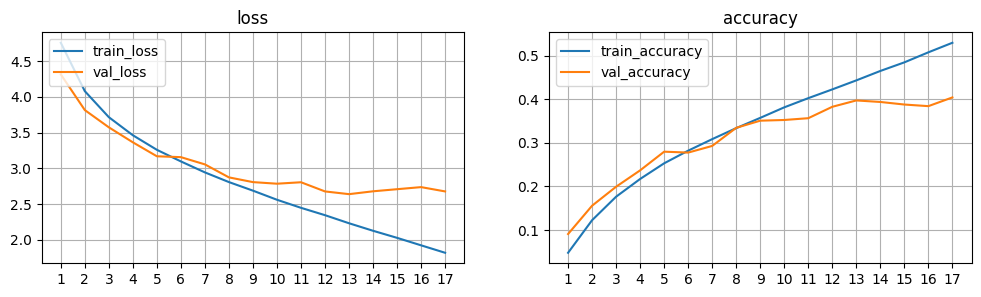

In [44]:
model8 = ResNet1().to(utils.device)
train(model8, 'resnet-08')

100%|██████████| 40/40 [00:01<00:00, 30.92it/s]


Epoch 1/1000: train_loss=4.7820, train_accuracy=0.0446, val_loss=4.4109, val_accuracy=0.0796
Saving params from epoch 1. Best loss: 4.4109


100%|██████████| 40/40 [00:01<00:00, 31.28it/s]


Epoch 2/1000: train_loss=4.1644, train_accuracy=0.1095, val_loss=4.1502, val_accuracy=0.1151
Saving params from epoch 2. Best loss: 4.1502


100%|██████████| 40/40 [00:01<00:00, 30.09it/s]


Epoch 3/1000: train_loss=3.8497, train_accuracy=0.1542, val_loss=3.7833, val_accuracy=0.1694
Saving params from epoch 3. Best loss: 3.7833


100%|██████████| 40/40 [00:01<00:00, 30.00it/s]


Epoch 4/1000: train_loss=3.6422, train_accuracy=0.1874, val_loss=3.5903, val_accuracy=0.2020
Saving params from epoch 4. Best loss: 3.5903


100%|██████████| 40/40 [00:01<00:00, 25.19it/s]


Epoch 5/1000: train_loss=3.4900, train_accuracy=0.2111, val_loss=3.4478, val_accuracy=0.2223
Saving params from epoch 5. Best loss: 3.4478


100%|██████████| 40/40 [00:01<00:00, 31.07it/s]


Epoch 6/1000: train_loss=3.3526, train_accuracy=0.2354, val_loss=3.3769, val_accuracy=0.2325
Saving params from epoch 6. Best loss: 3.3769


100%|██████████| 40/40 [00:01<00:00, 31.98it/s]


Epoch 7/1000: train_loss=3.2302, train_accuracy=0.2586, val_loss=3.1497, val_accuracy=0.2780
Saving params from epoch 7. Best loss: 3.1497


100%|██████████| 40/40 [00:01<00:00, 29.33it/s]


Epoch 8/1000: train_loss=3.1301, train_accuracy=0.2748, val_loss=3.1349, val_accuracy=0.2851
Saving params from epoch 8. Best loss: 3.1349


100%|██████████| 40/40 [00:01<00:00, 26.49it/s]


Epoch 9/1000: train_loss=3.0358, train_accuracy=0.2934, val_loss=3.0560, val_accuracy=0.2968
Saving params from epoch 9. Best loss: 3.0560


100%|██████████| 40/40 [00:01<00:00, 29.16it/s]


Epoch 10/1000: train_loss=2.9560, train_accuracy=0.3083, val_loss=2.9257, val_accuracy=0.3241
Saving params from epoch 10. Best loss: 2.9257


100%|██████████| 40/40 [00:01<00:00, 25.22it/s]


Epoch 11/1000: train_loss=2.8764, train_accuracy=0.3224, val_loss=3.0062, val_accuracy=0.3094


100%|██████████| 40/40 [00:01<00:00, 29.64it/s]


Epoch 12/1000: train_loss=2.8216, train_accuracy=0.3349, val_loss=3.0000, val_accuracy=0.3121


100%|██████████| 40/40 [00:01<00:00, 29.77it/s]


Epoch 13/1000: train_loss=2.7578, train_accuracy=0.3462, val_loss=2.8061, val_accuracy=0.3414
Saving params from epoch 13. Best loss: 2.8061


100%|██████████| 40/40 [00:01<00:00, 28.63it/s]


Epoch 14/1000: train_loss=2.7087, train_accuracy=0.3553, val_loss=2.8275, val_accuracy=0.3409


100%|██████████| 40/40 [00:01<00:00, 28.20it/s]


Epoch 15/1000: train_loss=2.6666, train_accuracy=0.3635, val_loss=2.8276, val_accuracy=0.3427


100%|██████████| 40/40 [00:01<00:00, 28.81it/s]


Epoch 16/1000: train_loss=2.6320, train_accuracy=0.3703, val_loss=2.8716, val_accuracy=0.3383


100%|██████████| 40/40 [00:01<00:00, 29.31it/s]


Epoch 17/1000: train_loss=2.5908, train_accuracy=0.3771, val_loss=2.7314, val_accuracy=0.3588
Saving params from epoch 17. Best loss: 2.7314


100%|██████████| 40/40 [00:01<00:00, 29.31it/s]


Epoch 18/1000: train_loss=2.5538, train_accuracy=0.3864, val_loss=2.6979, val_accuracy=0.3630
Saving params from epoch 18. Best loss: 2.6979


100%|██████████| 40/40 [00:01<00:00, 28.32it/s]


Epoch 19/1000: train_loss=2.5244, train_accuracy=0.3923, val_loss=2.6868, val_accuracy=0.3711
Saving params from epoch 19. Best loss: 2.6868


100%|██████████| 40/40 [00:01<00:00, 29.14it/s]


Epoch 20/1000: train_loss=2.4927, train_accuracy=0.3997, val_loss=2.6351, val_accuracy=0.3803
Saving params from epoch 20. Best loss: 2.6351


100%|██████████| 40/40 [00:01<00:00, 28.44it/s]


Epoch 21/1000: train_loss=2.4614, train_accuracy=0.4026, val_loss=2.5974, val_accuracy=0.3930
Saving params from epoch 21. Best loss: 2.5974


100%|██████████| 40/40 [00:01<00:00, 30.40it/s]


Epoch 22/1000: train_loss=2.4439, train_accuracy=0.4086, val_loss=2.6035, val_accuracy=0.3909


100%|██████████| 40/40 [00:01<00:00, 26.09it/s]


Epoch 23/1000: train_loss=2.4110, train_accuracy=0.4132, val_loss=2.8254, val_accuracy=0.3484


100%|██████████| 40/40 [00:01<00:00, 28.58it/s]


Epoch 24/1000: train_loss=2.3901, train_accuracy=0.4191, val_loss=2.5843, val_accuracy=0.3933
Saving params from epoch 24. Best loss: 2.5843


100%|██████████| 40/40 [00:01<00:00, 28.55it/s]


Epoch 25/1000: train_loss=2.3715, train_accuracy=0.4225, val_loss=2.5871, val_accuracy=0.3948


100%|██████████| 40/40 [00:01<00:00, 29.05it/s]


Epoch 26/1000: train_loss=2.3558, train_accuracy=0.4268, val_loss=2.5625, val_accuracy=0.3952
Saving params from epoch 26. Best loss: 2.5625


100%|██████████| 40/40 [00:01<00:00, 28.56it/s]


Epoch 27/1000: train_loss=2.3347, train_accuracy=0.4297, val_loss=2.6035, val_accuracy=0.3881


100%|██████████| 40/40 [00:01<00:00, 27.73it/s]


Epoch 28/1000: train_loss=2.3185, train_accuracy=0.4318, val_loss=2.6126, val_accuracy=0.3860


100%|██████████| 40/40 [00:01<00:00, 27.95it/s]


Epoch 29/1000: train_loss=2.3016, train_accuracy=0.4367, val_loss=2.5501, val_accuracy=0.4013
Saving params from epoch 29. Best loss: 2.5501


100%|██████████| 40/40 [00:01<00:00, 28.38it/s]


Epoch 30/1000: train_loss=2.2938, train_accuracy=0.4369, val_loss=2.5277, val_accuracy=0.4038
Saving params from epoch 30. Best loss: 2.5277


100%|██████████| 40/40 [00:01<00:00, 28.95it/s]


Epoch 31/1000: train_loss=2.2793, train_accuracy=0.4404, val_loss=2.4723, val_accuracy=0.4110
Saving params from epoch 31. Best loss: 2.4723


100%|██████████| 40/40 [00:01<00:00, 28.58it/s]


Epoch 32/1000: train_loss=2.2610, train_accuracy=0.4442, val_loss=2.4970, val_accuracy=0.4087


100%|██████████| 40/40 [00:01<00:00, 25.56it/s]


Epoch 33/1000: train_loss=2.2489, train_accuracy=0.4475, val_loss=2.5211, val_accuracy=0.4093


100%|██████████| 40/40 [00:01<00:00, 28.46it/s]


Epoch 34/1000: train_loss=2.2430, train_accuracy=0.4485, val_loss=2.5025, val_accuracy=0.4106


100%|██████████| 40/40 [00:01<00:00, 27.75it/s]


Epoch 35/1000: train_loss=2.2241, train_accuracy=0.4520, val_loss=2.4616, val_accuracy=0.4190
Saving params from epoch 35. Best loss: 2.4616


100%|██████████| 40/40 [00:01<00:00, 28.58it/s]


Epoch 36/1000: train_loss=2.2245, train_accuracy=0.4539, val_loss=2.5657, val_accuracy=0.4025


100%|██████████| 40/40 [00:01<00:00, 28.14it/s]


Epoch 37/1000: train_loss=2.2045, train_accuracy=0.4568, val_loss=2.4572, val_accuracy=0.4215
Saving params from epoch 37. Best loss: 2.4572


100%|██████████| 40/40 [00:01<00:00, 29.96it/s]


Epoch 38/1000: train_loss=2.1932, train_accuracy=0.4576, val_loss=2.5115, val_accuracy=0.4101


100%|██████████| 40/40 [00:01<00:00, 28.77it/s]


Epoch 39/1000: train_loss=2.1802, train_accuracy=0.4607, val_loss=2.5522, val_accuracy=0.4038


100%|██████████| 40/40 [00:01<00:00, 28.73it/s]


Epoch 40/1000: train_loss=2.1779, train_accuracy=0.4606, val_loss=2.4997, val_accuracy=0.4146


100%|██████████| 40/40 [00:01<00:00, 29.31it/s]


Epoch 41/1000: train_loss=2.1725, train_accuracy=0.4629, val_loss=2.4886, val_accuracy=0.4195
Loading model params from epoch 37
{'loss': 2.4460413188934327, 'accuracy': 0.4204}


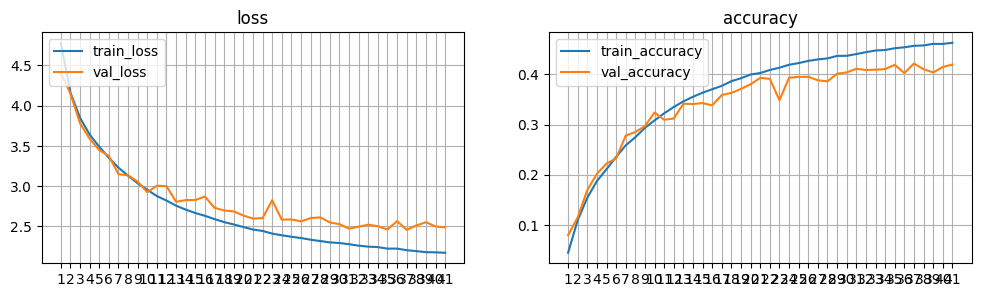

In [45]:
model9 = ResNet1().to(utils.device)
train(model9, 'resnet-09', weight_decay=5e-4)

100%|██████████| 40/40 [00:01<00:00, 25.49it/s]


Epoch 1/1000: train_loss=4.9656, train_accuracy=0.0292, val_loss=4.5777, val_accuracy=0.0540
Saving params from epoch 1. Best loss: 4.5777


100%|██████████| 40/40 [00:01<00:00, 30.69it/s]


Epoch 2/1000: train_loss=4.3985, train_accuracy=0.0782, val_loss=4.1205, val_accuracy=0.1164
Saving params from epoch 2. Best loss: 4.1205


100%|██████████| 40/40 [00:01<00:00, 30.25it/s]


Epoch 3/1000: train_loss=4.0811, train_accuracy=0.1185, val_loss=3.7873, val_accuracy=0.1597
Saving params from epoch 3. Best loss: 3.7873


100%|██████████| 40/40 [00:01<00:00, 29.47it/s]


Epoch 4/1000: train_loss=3.8939, train_accuracy=0.1452, val_loss=3.6774, val_accuracy=0.1809
Saving params from epoch 4. Best loss: 3.6774


100%|██████████| 40/40 [00:01<00:00, 30.30it/s]


Epoch 5/1000: train_loss=3.7446, train_accuracy=0.1676, val_loss=3.5262, val_accuracy=0.2052
Saving params from epoch 5. Best loss: 3.5262


100%|██████████| 40/40 [00:01<00:00, 29.55it/s]


Epoch 6/1000: train_loss=3.6148, train_accuracy=0.1891, val_loss=3.3572, val_accuracy=0.2355
Saving params from epoch 6. Best loss: 3.3572


100%|██████████| 40/40 [00:01<00:00, 30.16it/s]


Epoch 7/1000: train_loss=3.5006, train_accuracy=0.2077, val_loss=3.2373, val_accuracy=0.2578
Saving params from epoch 7. Best loss: 3.2373


100%|██████████| 40/40 [00:01<00:00, 28.13it/s]


Epoch 8/1000: train_loss=3.3855, train_accuracy=0.2289, val_loss=3.2651, val_accuracy=0.2557


100%|██████████| 40/40 [00:01<00:00, 25.18it/s]


Epoch 9/1000: train_loss=3.3084, train_accuracy=0.2441, val_loss=3.1049, val_accuracy=0.2811
Saving params from epoch 9. Best loss: 3.1049


100%|██████████| 40/40 [00:01<00:00, 25.12it/s]


Epoch 10/1000: train_loss=3.2295, train_accuracy=0.2563, val_loss=3.0538, val_accuracy=0.2945
Saving params from epoch 10. Best loss: 3.0538


100%|██████████| 40/40 [00:01<00:00, 29.14it/s]


Epoch 11/1000: train_loss=3.1619, train_accuracy=0.2699, val_loss=3.1305, val_accuracy=0.2821


100%|██████████| 40/40 [00:01<00:00, 29.61it/s]


Epoch 12/1000: train_loss=3.1028, train_accuracy=0.2799, val_loss=2.9746, val_accuracy=0.3082
Saving params from epoch 12. Best loss: 2.9746


100%|██████████| 40/40 [00:01<00:00, 29.14it/s]


Epoch 13/1000: train_loss=3.0480, train_accuracy=0.2896, val_loss=2.9500, val_accuracy=0.3134
Saving params from epoch 13. Best loss: 2.9500


100%|██████████| 40/40 [00:01<00:00, 28.59it/s]


Epoch 14/1000: train_loss=3.0052, train_accuracy=0.3002, val_loss=2.8599, val_accuracy=0.3267
Saving params from epoch 14. Best loss: 2.8599


100%|██████████| 40/40 [00:01<00:00, 28.76it/s]


Epoch 15/1000: train_loss=2.9645, train_accuracy=0.3083, val_loss=2.9289, val_accuracy=0.3177


100%|██████████| 40/40 [00:01<00:00, 30.15it/s]


Epoch 16/1000: train_loss=2.9243, train_accuracy=0.3156, val_loss=2.8337, val_accuracy=0.3414
Saving params from epoch 16. Best loss: 2.8337


100%|██████████| 40/40 [00:01<00:00, 29.20it/s]


Epoch 17/1000: train_loss=2.8862, train_accuracy=0.3227, val_loss=2.8648, val_accuracy=0.3323


100%|██████████| 40/40 [00:01<00:00, 28.80it/s]


Epoch 18/1000: train_loss=2.8602, train_accuracy=0.3291, val_loss=2.8200, val_accuracy=0.3376
Saving params from epoch 18. Best loss: 2.8200


100%|██████████| 40/40 [00:01<00:00, 29.37it/s]


Epoch 19/1000: train_loss=2.8301, train_accuracy=0.3332, val_loss=2.7065, val_accuracy=0.3654
Saving params from epoch 19. Best loss: 2.7065


100%|██████████| 40/40 [00:01<00:00, 29.13it/s]


Epoch 20/1000: train_loss=2.8004, train_accuracy=0.3384, val_loss=2.7214, val_accuracy=0.3642


100%|██████████| 40/40 [00:01<00:00, 29.05it/s]


Epoch 21/1000: train_loss=2.7739, train_accuracy=0.3452, val_loss=2.7876, val_accuracy=0.3506


100%|██████████| 40/40 [00:01<00:00, 28.53it/s]


Epoch 22/1000: train_loss=2.7498, train_accuracy=0.3517, val_loss=2.7336, val_accuracy=0.3637


100%|██████████| 40/40 [00:01<00:00, 29.33it/s]


Epoch 23/1000: train_loss=2.7343, train_accuracy=0.3546, val_loss=2.7377, val_accuracy=0.3623
Loading model params from epoch 19
{'loss': 2.694533197593689, 'accuracy': 0.3612}


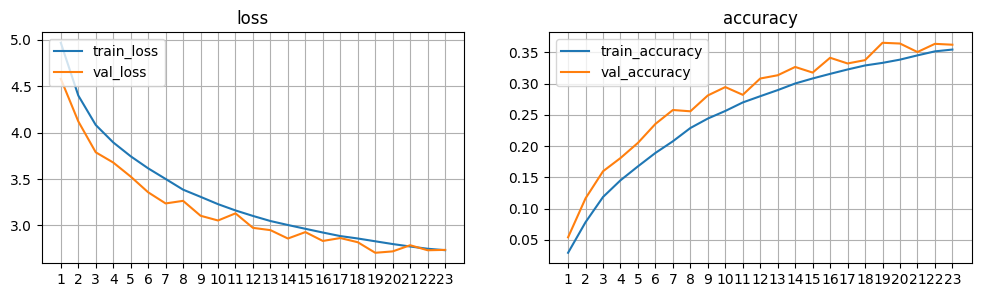

In [46]:
model10 = ResNet2().to(utils.device)
train(model10, 'resnet-10', weight_decay=5e-4)

In [52]:
class ResNet3(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            ResNetSimpleBlock(in_channels=64, out_channels=64, down_sampling=False),
            ResNetSimpleBlock(in_channels=64, out_channels=64, down_sampling=False),
            ResNetSimpleBlock(in_channels=64, out_channels=128, down_sampling=True),
            ResNetSimpleBlock(in_channels=128, out_channels=128, down_sampling=False),
            ResNetSimpleBlock(in_channels=128, out_channels=256, down_sampling=True),
            ResNetSimpleBlock(in_channels=256, out_channels=256, down_sampling=False),
            ResNetSimpleBlock(in_channels=256, out_channels=512, down_sampling=True),
            ResNetSimpleBlock(in_channels=512, out_channels=512, down_sampling=False),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(in_features=512, out_features=200)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            # Zero-initialize the last BN in each residual branch,
            # so that the residual branch starts with zeros, and each residual block behaves like an identity.
            # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
            elif isinstance(m, ResNetSimpleBlock):
                nn.init.constant_(m.layers[-1].weight, 0) 


    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

ResNet3()(sample_img).shape

torch.Size([1, 200])

100%|██████████| 40/40 [00:01<00:00, 30.15it/s]


Epoch 1/1000: train_loss=4.7411, train_accuracy=0.0487, val_loss=4.4033, val_accuracy=0.0811
Saving params from epoch 1. Best loss: 4.4033


100%|██████████| 40/40 [00:01<00:00, 30.69it/s]


Epoch 2/1000: train_loss=4.1251, train_accuracy=0.1150, val_loss=3.9432, val_accuracy=0.1343
Saving params from epoch 2. Best loss: 3.9432


100%|██████████| 40/40 [00:01<00:00, 30.78it/s]


Epoch 3/1000: train_loss=3.8223, train_accuracy=0.1572, val_loss=3.6787, val_accuracy=0.1754
Saving params from epoch 3. Best loss: 3.6787


100%|██████████| 40/40 [00:01<00:00, 29.53it/s]


Epoch 4/1000: train_loss=3.6065, train_accuracy=0.1906, val_loss=3.5967, val_accuracy=0.1987
Saving params from epoch 4. Best loss: 3.5967


100%|██████████| 40/40 [00:01<00:00, 26.71it/s]


Epoch 5/1000: train_loss=3.4513, train_accuracy=0.2187, val_loss=3.4239, val_accuracy=0.2249
Saving params from epoch 5. Best loss: 3.4239


100%|██████████| 40/40 [00:01<00:00, 29.24it/s]


Epoch 6/1000: train_loss=3.3110, train_accuracy=0.2415, val_loss=3.3886, val_accuracy=0.2351
Saving params from epoch 6. Best loss: 3.3886


100%|██████████| 40/40 [00:01<00:00, 29.74it/s]


Epoch 7/1000: train_loss=3.1875, train_accuracy=0.2623, val_loss=3.1956, val_accuracy=0.2662
Saving params from epoch 7. Best loss: 3.1956


100%|██████████| 40/40 [00:01<00:00, 30.09it/s]


Epoch 8/1000: train_loss=3.0857, train_accuracy=0.2831, val_loss=3.0686, val_accuracy=0.2912
Saving params from epoch 8. Best loss: 3.0686


100%|██████████| 40/40 [00:01<00:00, 29.81it/s]


Epoch 9/1000: train_loss=2.9970, train_accuracy=0.2994, val_loss=3.0128, val_accuracy=0.2998
Saving params from epoch 9. Best loss: 3.0128


100%|██████████| 40/40 [00:01<00:00, 24.55it/s]


Epoch 10/1000: train_loss=2.9172, train_accuracy=0.3146, val_loss=2.9080, val_accuracy=0.3263
Saving params from epoch 10. Best loss: 2.9080


100%|██████████| 40/40 [00:01<00:00, 29.19it/s]


Epoch 11/1000: train_loss=2.8505, train_accuracy=0.3268, val_loss=2.8410, val_accuracy=0.3375
Saving params from epoch 11. Best loss: 2.8410


100%|██████████| 40/40 [00:01<00:00, 29.23it/s]


Epoch 12/1000: train_loss=2.7952, train_accuracy=0.3395, val_loss=3.0348, val_accuracy=0.3004


100%|██████████| 40/40 [00:01<00:00, 29.01it/s]


Epoch 13/1000: train_loss=2.7478, train_accuracy=0.3476, val_loss=2.7775, val_accuracy=0.3521
Saving params from epoch 13. Best loss: 2.7775


100%|██████████| 40/40 [00:01<00:00, 28.19it/s]


Epoch 14/1000: train_loss=2.6893, train_accuracy=0.3600, val_loss=2.8080, val_accuracy=0.3442


100%|██████████| 40/40 [00:01<00:00, 28.52it/s]


Epoch 15/1000: train_loss=2.6580, train_accuracy=0.3658, val_loss=2.7781, val_accuracy=0.3542


100%|██████████| 40/40 [00:01<00:00, 29.61it/s]


Epoch 16/1000: train_loss=2.6129, train_accuracy=0.3727, val_loss=2.7483, val_accuracy=0.3623
Saving params from epoch 16. Best loss: 2.7483


100%|██████████| 40/40 [00:01<00:00, 28.49it/s]


Epoch 17/1000: train_loss=2.5725, train_accuracy=0.3832, val_loss=2.7008, val_accuracy=0.3687
Saving params from epoch 17. Best loss: 2.7008


100%|██████████| 40/40 [00:01<00:00, 29.64it/s]


Epoch 18/1000: train_loss=2.5430, train_accuracy=0.3866, val_loss=2.7320, val_accuracy=0.3634


100%|██████████| 40/40 [00:01<00:00, 30.78it/s]


Epoch 19/1000: train_loss=2.5118, train_accuracy=0.3928, val_loss=2.6962, val_accuracy=0.3707
Saving params from epoch 19. Best loss: 2.6962


100%|██████████| 40/40 [00:01<00:00, 26.55it/s]


Epoch 20/1000: train_loss=2.4856, train_accuracy=0.3967, val_loss=2.6269, val_accuracy=0.3816
Saving params from epoch 20. Best loss: 2.6269


100%|██████████| 40/40 [00:01<00:00, 28.62it/s]


Epoch 21/1000: train_loss=2.4594, train_accuracy=0.4028, val_loss=2.6719, val_accuracy=0.3779


100%|██████████| 40/40 [00:01<00:00, 27.32it/s]


Epoch 22/1000: train_loss=2.4338, train_accuracy=0.4096, val_loss=2.6231, val_accuracy=0.3822
Saving params from epoch 22. Best loss: 2.6231


100%|██████████| 40/40 [00:01<00:00, 30.92it/s]


Epoch 23/1000: train_loss=2.4134, train_accuracy=0.4125, val_loss=2.6230, val_accuracy=0.3869
Saving params from epoch 23. Best loss: 2.6230


100%|██████████| 40/40 [00:01<00:00, 28.07it/s]


Epoch 24/1000: train_loss=2.3927, train_accuracy=0.4181, val_loss=2.6280, val_accuracy=0.3845


100%|██████████| 40/40 [00:01<00:00, 28.60it/s]


Epoch 25/1000: train_loss=2.3734, train_accuracy=0.4213, val_loss=2.5687, val_accuracy=0.3965
Saving params from epoch 25. Best loss: 2.5687


100%|██████████| 40/40 [00:01<00:00, 26.84it/s]


Epoch 26/1000: train_loss=2.3503, train_accuracy=0.4254, val_loss=2.5407, val_accuracy=0.3992
Saving params from epoch 26. Best loss: 2.5407


100%|██████████| 40/40 [00:01<00:00, 28.45it/s]


Epoch 27/1000: train_loss=2.3377, train_accuracy=0.4283, val_loss=2.5374, val_accuracy=0.4011
Saving params from epoch 27. Best loss: 2.5374


100%|██████████| 40/40 [00:01<00:00, 28.62it/s]


Epoch 28/1000: train_loss=2.3188, train_accuracy=0.4334, val_loss=2.5138, val_accuracy=0.4037
Saving params from epoch 28. Best loss: 2.5138


100%|██████████| 40/40 [00:01<00:00, 28.09it/s]


Epoch 29/1000: train_loss=2.3021, train_accuracy=0.4349, val_loss=2.5268, val_accuracy=0.4000


100%|██████████| 40/40 [00:01<00:00, 26.80it/s]


Epoch 30/1000: train_loss=2.2875, train_accuracy=0.4384, val_loss=2.5431, val_accuracy=0.4029


100%|██████████| 40/40 [00:01<00:00, 29.30it/s]


Epoch 31/1000: train_loss=2.2720, train_accuracy=0.4413, val_loss=2.5282, val_accuracy=0.4051


100%|██████████| 40/40 [00:01<00:00, 28.26it/s]


Epoch 32/1000: train_loss=2.2599, train_accuracy=0.4461, val_loss=2.5010, val_accuracy=0.4065
Saving params from epoch 32. Best loss: 2.5010


100%|██████████| 40/40 [00:01<00:00, 29.26it/s]


Epoch 33/1000: train_loss=2.2464, train_accuracy=0.4481, val_loss=2.4850, val_accuracy=0.4116
Saving params from epoch 33. Best loss: 2.4850


100%|██████████| 40/40 [00:01<00:00, 27.89it/s]


Epoch 34/1000: train_loss=2.2299, train_accuracy=0.4506, val_loss=2.4978, val_accuracy=0.4101


100%|██████████| 40/40 [00:01<00:00, 29.09it/s]


Epoch 35/1000: train_loss=2.2224, train_accuracy=0.4518, val_loss=2.4413, val_accuracy=0.4196
Saving params from epoch 35. Best loss: 2.4413


100%|██████████| 40/40 [00:01<00:00, 29.35it/s]


Epoch 36/1000: train_loss=2.2034, train_accuracy=0.4551, val_loss=2.4462, val_accuracy=0.4218


100%|██████████| 40/40 [00:01<00:00, 28.72it/s]


Epoch 37/1000: train_loss=2.1922, train_accuracy=0.4606, val_loss=2.5174, val_accuracy=0.4119


100%|██████████| 40/40 [00:01<00:00, 25.57it/s]


Epoch 38/1000: train_loss=2.1896, train_accuracy=0.4582, val_loss=2.5114, val_accuracy=0.4075


100%|██████████| 40/40 [00:01<00:00, 28.60it/s]

Epoch 39/1000: train_loss=2.1833, train_accuracy=0.4611, val_loss=2.4683, val_accuracy=0.4191
Loading model params from epoch 35


{'loss': 2.431052541732788, 'accuracy': 0.4193}


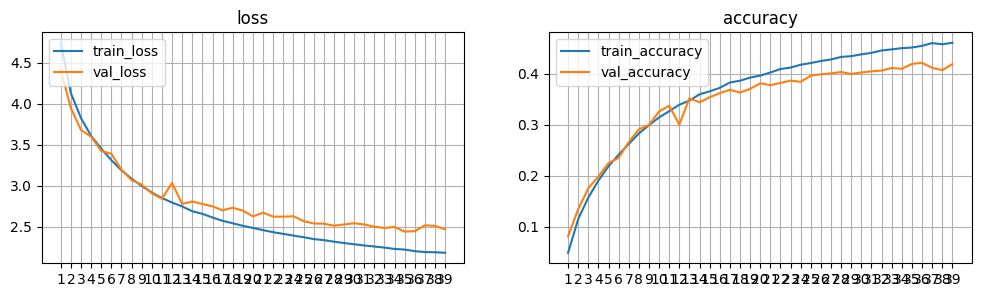

In [53]:
model11 = ResNet3().to(utils.device)
train(model11, 'resnet-11', weight_decay=5e-4)

In [54]:
train_dl, valid_dl, test_dl = utils.make_tiny_imagenet_dataloaders(batch_size=32, normalize=True, augment=True)
len(train_dl.dataset), len(valid_dl.dataset), len(test_dl.dataset)

(90000, 10000, 10000)

100%|██████████| 313/313 [00:02<00:00, 112.64it/s]


Epoch 1/1000: train_loss=4.9714, train_accuracy=0.0258, val_loss=4.6188, val_accuracy=0.0545
Saving params from epoch 1. Best loss: 4.6188


100%|██████████| 313/313 [00:03<00:00, 97.16it/s] 


Epoch 2/1000: train_loss=4.4049, train_accuracy=0.0768, val_loss=4.0599, val_accuracy=0.1122
Saving params from epoch 2. Best loss: 4.0599


100%|██████████| 313/313 [00:03<00:00, 102.85it/s]


Epoch 3/1000: train_loss=4.0707, train_accuracy=0.1207, val_loss=3.7188, val_accuracy=0.1697
Saving params from epoch 3. Best loss: 3.7188


100%|██████████| 313/313 [00:03<00:00, 100.11it/s]


Epoch 4/1000: train_loss=3.8888, train_accuracy=0.1472, val_loss=3.6032, val_accuracy=0.1885
Saving params from epoch 4. Best loss: 3.6032


100%|██████████| 313/313 [00:02<00:00, 108.54it/s]


Epoch 5/1000: train_loss=3.7713, train_accuracy=0.1662, val_loss=3.6700, val_accuracy=0.1844


100%|██████████| 313/313 [00:02<00:00, 115.95it/s]


Epoch 6/1000: train_loss=3.6894, train_accuracy=0.1801, val_loss=3.3991, val_accuracy=0.2243
Saving params from epoch 6. Best loss: 3.3991


100%|██████████| 313/313 [00:02<00:00, 106.92it/s]


Epoch 7/1000: train_loss=3.6206, train_accuracy=0.1940, val_loss=3.3929, val_accuracy=0.2261
Saving params from epoch 7. Best loss: 3.3929


100%|██████████| 313/313 [00:03<00:00, 102.59it/s]


Epoch 8/1000: train_loss=3.5612, train_accuracy=0.2006, val_loss=3.3611, val_accuracy=0.2358
Saving params from epoch 8. Best loss: 3.3611


100%|██████████| 313/313 [00:02<00:00, 106.87it/s]


Epoch 9/1000: train_loss=3.5207, train_accuracy=0.2096, val_loss=3.3055, val_accuracy=0.2422
Saving params from epoch 9. Best loss: 3.3055


100%|██████████| 313/313 [00:02<00:00, 105.47it/s]


Epoch 10/1000: train_loss=3.4768, train_accuracy=0.2163, val_loss=3.3212, val_accuracy=0.2356


100%|██████████| 313/313 [00:03<00:00, 103.62it/s]


Epoch 11/1000: train_loss=3.4535, train_accuracy=0.2219, val_loss=3.2403, val_accuracy=0.2551
Saving params from epoch 11. Best loss: 3.2403


100%|██████████| 313/313 [00:03<00:00, 102.16it/s]


Epoch 12/1000: train_loss=3.4124, train_accuracy=0.2263, val_loss=3.2544, val_accuracy=0.2531


100%|██████████| 313/313 [00:03<00:00, 101.68it/s]


Epoch 13/1000: train_loss=3.3903, train_accuracy=0.2332, val_loss=3.1881, val_accuracy=0.2674
Saving params from epoch 13. Best loss: 3.1881


100%|██████████| 313/313 [00:02<00:00, 105.58it/s]


Epoch 14/1000: train_loss=3.3653, train_accuracy=0.2379, val_loss=3.2001, val_accuracy=0.2626


100%|██████████| 313/313 [00:03<00:00, 100.68it/s]


Epoch 15/1000: train_loss=3.3434, train_accuracy=0.2391, val_loss=3.0956, val_accuracy=0.2831
Saving params from epoch 15. Best loss: 3.0956


100%|██████████| 313/313 [00:02<00:00, 111.30it/s]


Epoch 16/1000: train_loss=3.3174, train_accuracy=0.2453, val_loss=3.1694, val_accuracy=0.2675


100%|██████████| 313/313 [00:03<00:00, 103.69it/s]


Epoch 17/1000: train_loss=3.3005, train_accuracy=0.2493, val_loss=3.1245, val_accuracy=0.2800


100%|██████████| 313/313 [00:03<00:00, 100.73it/s]


Epoch 18/1000: train_loss=3.2871, train_accuracy=0.2511, val_loss=3.0860, val_accuracy=0.2858
Saving params from epoch 18. Best loss: 3.0860


100%|██████████| 313/313 [00:02<00:00, 106.29it/s]


Epoch 19/1000: train_loss=3.2736, train_accuracy=0.2522, val_loss=3.1153, val_accuracy=0.2764


100%|██████████| 313/313 [00:03<00:00, 97.03it/s] 


Epoch 20/1000: train_loss=3.2608, train_accuracy=0.2538, val_loss=3.0827, val_accuracy=0.2886
Saving params from epoch 20. Best loss: 3.0827


100%|██████████| 313/313 [00:03<00:00, 103.61it/s]


Epoch 21/1000: train_loss=3.2437, train_accuracy=0.2575, val_loss=3.0627, val_accuracy=0.2885
Saving params from epoch 21. Best loss: 3.0627


100%|██████████| 313/313 [00:02<00:00, 104.49it/s]


Epoch 22/1000: train_loss=3.2336, train_accuracy=0.2591, val_loss=3.0611, val_accuracy=0.2901
Saving params from epoch 22. Best loss: 3.0611


100%|██████████| 313/313 [00:03<00:00, 101.23it/s]


Epoch 23/1000: train_loss=3.2237, train_accuracy=0.2605, val_loss=3.0745, val_accuracy=0.2818


100%|██████████| 313/313 [00:02<00:00, 112.51it/s]


Epoch 24/1000: train_loss=3.2228, train_accuracy=0.2631, val_loss=2.9972, val_accuracy=0.2969
Saving params from epoch 24. Best loss: 2.9972


100%|██████████| 313/313 [00:02<00:00, 109.73it/s]


Epoch 25/1000: train_loss=3.2071, train_accuracy=0.2648, val_loss=3.0314, val_accuracy=0.2937


100%|██████████| 313/313 [00:03<00:00, 103.31it/s]


Epoch 26/1000: train_loss=3.1938, train_accuracy=0.2664, val_loss=3.0811, val_accuracy=0.2914


100%|██████████| 313/313 [00:03<00:00, 103.90it/s]


Epoch 27/1000: train_loss=3.1928, train_accuracy=0.2657, val_loss=3.0925, val_accuracy=0.2853


100%|██████████| 313/313 [00:02<00:00, 105.48it/s]


Epoch 28/1000: train_loss=3.1834, train_accuracy=0.2695, val_loss=3.0153, val_accuracy=0.2934
Loading model params from epoch 24
{'loss': 3.026282118225098, 'accuracy': 0.2862}


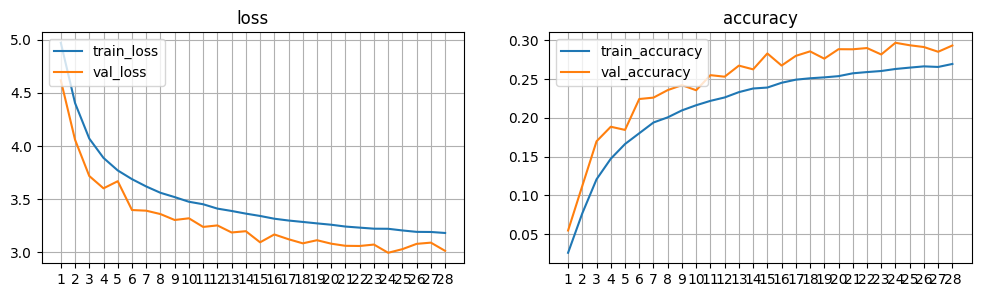

In [56]:
model12 = ResNet3().to(utils.device)
train(model12, 'resnet-12', weight_decay=5e-4)

100%|██████████| 313/313 [00:02<00:00, 111.87it/s]


Epoch 1/1000: train_loss=4.8559, train_accuracy=0.0376, val_loss=4.3141, val_accuracy=0.0946
Saving params from epoch 1. Best loss: 4.3141


100%|██████████| 313/313 [00:02<00:00, 104.53it/s]


Epoch 2/1000: train_loss=4.1916, train_accuracy=0.1107, val_loss=3.9257, val_accuracy=0.1603
Saving params from epoch 2. Best loss: 3.9257


100%|██████████| 313/313 [00:02<00:00, 110.86it/s]


Epoch 3/1000: train_loss=3.8251, train_accuracy=0.1635, val_loss=3.6494, val_accuracy=0.2104
Saving params from epoch 3. Best loss: 3.6494


100%|██████████| 313/313 [00:03<00:00, 97.45it/s] 


Epoch 4/1000: train_loss=3.5628, train_accuracy=0.2033, val_loss=3.3113, val_accuracy=0.2490
Saving params from epoch 4. Best loss: 3.3113


100%|██████████| 313/313 [00:03<00:00, 102.16it/s]


Epoch 5/1000: train_loss=3.3666, train_accuracy=0.2370, val_loss=3.2058, val_accuracy=0.2726
Saving params from epoch 5. Best loss: 3.2058


100%|██████████| 313/313 [00:02<00:00, 116.79it/s]


Epoch 6/1000: train_loss=3.2032, train_accuracy=0.2655, val_loss=3.2335, val_accuracy=0.2916


100%|██████████| 313/313 [00:03<00:00, 99.46it/s] 


Epoch 7/1000: train_loss=3.0638, train_accuracy=0.2911, val_loss=3.1588, val_accuracy=0.3149
Saving params from epoch 7. Best loss: 3.1588


100%|██████████| 313/313 [00:03<00:00, 101.24it/s]


Epoch 8/1000: train_loss=2.9419, train_accuracy=0.3130, val_loss=2.9700, val_accuracy=0.3254
Saving params from epoch 8. Best loss: 2.9700


100%|██████████| 313/313 [00:02<00:00, 104.82it/s]


Epoch 9/1000: train_loss=2.8193, train_accuracy=0.3361, val_loss=2.9290, val_accuracy=0.3351
Saving params from epoch 9. Best loss: 2.9290


100%|██████████| 313/313 [00:02<00:00, 111.98it/s]


Epoch 10/1000: train_loss=2.7144, train_accuracy=0.3547, val_loss=2.9528, val_accuracy=0.3475


100%|██████████| 313/313 [00:03<00:00, 102.41it/s]


Epoch 11/1000: train_loss=2.6169, train_accuracy=0.3714, val_loss=2.8049, val_accuracy=0.3595
Saving params from epoch 11. Best loss: 2.8049


100%|██████████| 313/313 [00:02<00:00, 109.73it/s]


Epoch 12/1000: train_loss=2.5154, train_accuracy=0.3919, val_loss=2.8139, val_accuracy=0.3520


100%|██████████| 313/313 [00:02<00:00, 114.20it/s]


Epoch 13/1000: train_loss=2.4087, train_accuracy=0.4106, val_loss=2.6888, val_accuracy=0.3771
Saving params from epoch 13. Best loss: 2.6888


100%|██████████| 313/313 [00:02<00:00, 112.40it/s]


Epoch 14/1000: train_loss=2.3228, train_accuracy=0.4271, val_loss=2.7114, val_accuracy=0.3773


100%|██████████| 313/313 [00:03<00:00, 102.29it/s]


Epoch 15/1000: train_loss=2.2241, train_accuracy=0.4474, val_loss=2.7047, val_accuracy=0.3788


100%|██████████| 313/313 [00:03<00:00, 103.54it/s]


Epoch 16/1000: train_loss=2.1351, train_accuracy=0.4650, val_loss=2.7096, val_accuracy=0.3874


100%|██████████| 313/313 [00:02<00:00, 104.67it/s]

Epoch 17/1000: train_loss=2.0381, train_accuracy=0.4846, val_loss=2.7353, val_accuracy=0.3881
Loading model params from epoch 13


{'loss': 2.7078101333618165, 'accuracy': 0.3757}


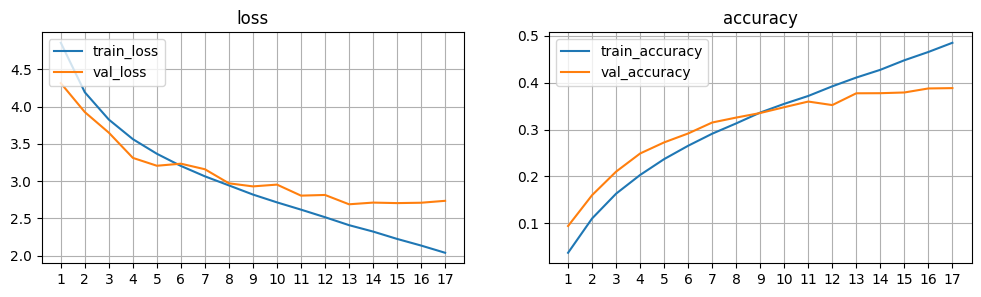

In [57]:
model13 = ResNet3().to(utils.device)
train(model13, 'resnet-13')

In [112]:
train_dl, valid_dl, test_dl = utils.make_tiny_imagenet_dataloaders(batch_size=64, normalize=True, augment=True)
len(train_dl.dataset), len(valid_dl.dataset), len(test_dl.dataset)

(90000, 10000, 10000)

100%|██████████| 157/157 [00:02<00:00, 72.55it/s]


Epoch 1/1000: train_loss=4.7786, train_accuracy=0.0453, val_loss=4.2346, val_accuracy=0.0946
Saving params from epoch 1. Best loss: 4.2346


100%|██████████| 157/157 [00:01<00:00, 96.02it/s] 


Epoch 2/1000: train_loss=4.1168, train_accuracy=0.1179, val_loss=3.7572, val_accuracy=0.1663
Saving params from epoch 2. Best loss: 3.7572


100%|██████████| 157/157 [00:01<00:00, 93.95it/s] 


Epoch 3/1000: train_loss=3.7491, train_accuracy=0.1716, val_loss=3.5027, val_accuracy=0.2130
Saving params from epoch 3. Best loss: 3.5027


100%|██████████| 157/157 [00:01<00:00, 104.28it/s]


Epoch 4/1000: train_loss=3.4929, train_accuracy=0.2138, val_loss=3.4670, val_accuracy=0.2323
Saving params from epoch 4. Best loss: 3.4670


100%|██████████| 157/157 [00:01<00:00, 90.09it/s]


Epoch 5/1000: train_loss=3.2945, train_accuracy=0.2501, val_loss=3.1167, val_accuracy=0.2867
Saving params from epoch 5. Best loss: 3.1167


100%|██████████| 157/157 [00:01<00:00, 95.69it/s] 


Epoch 6/1000: train_loss=3.1192, train_accuracy=0.2810, val_loss=3.0417, val_accuracy=0.2995
Saving params from epoch 6. Best loss: 3.0417


100%|██████████| 157/157 [00:01<00:00, 93.02it/s] 


Epoch 7/1000: train_loss=2.9827, train_accuracy=0.3061, val_loss=2.9228, val_accuracy=0.3228
Saving params from epoch 7. Best loss: 2.9228


100%|██████████| 157/157 [00:01<00:00, 92.98it/s] 


Epoch 8/1000: train_loss=2.8460, train_accuracy=0.3294, val_loss=2.8826, val_accuracy=0.3415
Saving params from epoch 8. Best loss: 2.8826


100%|██████████| 157/157 [00:02<00:00, 77.20it/s]


Epoch 9/1000: train_loss=2.7271, train_accuracy=0.3519, val_loss=2.8840, val_accuracy=0.3367


100%|██████████| 157/157 [00:02<00:00, 66.55it/s]


Epoch 10/1000: train_loss=2.6108, train_accuracy=0.3726, val_loss=2.8803, val_accuracy=0.3414
Saving params from epoch 10. Best loss: 2.8803


100%|██████████| 157/157 [00:01<00:00, 92.08it/s] 


Epoch 11/1000: train_loss=2.4998, train_accuracy=0.3954, val_loss=2.8309, val_accuracy=0.3588
Saving params from epoch 11. Best loss: 2.8309


100%|██████████| 157/157 [00:01<00:00, 85.93it/s]


Epoch 12/1000: train_loss=2.4024, train_accuracy=0.4124, val_loss=2.7369, val_accuracy=0.3689
Saving params from epoch 12. Best loss: 2.7369


100%|██████████| 157/157 [00:02<00:00, 71.99it/s]


Epoch 13/1000: train_loss=2.2954, train_accuracy=0.4356, val_loss=2.7638, val_accuracy=0.3699


100%|██████████| 157/157 [00:01<00:00, 85.91it/s]


Epoch 14/1000: train_loss=2.1955, train_accuracy=0.4552, val_loss=2.7525, val_accuracy=0.3808


100%|██████████| 157/157 [00:01<00:00, 90.46it/s] 


Epoch 15/1000: train_loss=2.0941, train_accuracy=0.4719, val_loss=2.7348, val_accuracy=0.3843
Saving params from epoch 15. Best loss: 2.7348


100%|██████████| 157/157 [00:02<00:00, 73.13it/s]


Epoch 16/1000: train_loss=1.9956, train_accuracy=0.4934, val_loss=2.7722, val_accuracy=0.3901


100%|██████████| 157/157 [00:01<00:00, 83.97it/s] 


Epoch 17/1000: train_loss=1.8892, train_accuracy=0.5156, val_loss=2.7927, val_accuracy=0.3844


100%|██████████| 157/157 [00:01<00:00, 80.43it/s]


Epoch 18/1000: train_loss=1.7834, train_accuracy=0.5369, val_loss=2.8534, val_accuracy=0.3798


100%|██████████| 157/157 [00:02<00:00, 70.35it/s]


Epoch 19/1000: train_loss=1.6866, train_accuracy=0.5573, val_loss=2.8430, val_accuracy=0.3968
Loading model params from epoch 15
{'loss': 2.7450988147735598, 'accuracy': 0.3753}


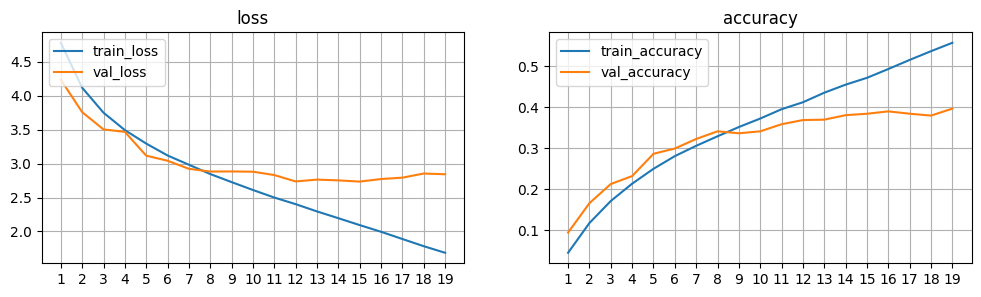

In [59]:
model14 = ResNet3().to(utils.device)
train(model14, 'resnet-14')

In [101]:
class ResNet18Transfer(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrained = resnet18(weights=ResNet18_Weights.DEFAULT).to(utils.device)
        self.projection = nn.Linear(1000, 200)
        # for param in self.pretrained.parameters():
            # param.requires_grad = False

    def forward(self, x):
        x = self.pretrained(x)
        x = self.projection(x)
        return x
        
model15 = ResNet18Transfer().to(utils.device)
utils.print_params(model15)

pretrained.conv1                 weight              ✅ 9.41 k     [64, 3, 7, 7]
pretrained.bn1                   weight              ✅ 64.0       [64]
                                 bias                ✅ 64.0       [64]
                                 running_mean        ⛔ 64.0       [64]
                                 running_var         ⛔ 64.0       [64]
                                 num_batches_tracked ⛔ 1.00       []
pretrained.layer1.0.conv1        weight              ✅ 36.9 k     [64, 64, 3, 3]
pretrained.layer1.0.bn1          weight              ✅ 64.0       [64]
                                 bias                ✅ 64.0       [64]
                                 running_mean        ⛔ 64.0       [64]
                                 running_var         ⛔ 64.0       [64]
                                 num_batches_tracked ⛔ 1.00       []
pretrained.layer1.0.conv2        weight              ✅ 36.9 k     [64, 64, 3, 3]
pretrained.layer1.0.bn2          weight             

100%|██████████| 40/40 [00:01<00:00, 32.46it/s]


Epoch 1/1000: train_loss=3.6254, train_accuracy=0.1985, val_loss=3.0914, val_accuracy=0.2820
Saving params from epoch 1. Best loss: 3.0914


100%|██████████| 40/40 [00:01<00:00, 30.85it/s]


Epoch 2/1000: train_loss=2.9506, train_accuracy=0.3060, val_loss=2.9873, val_accuracy=0.3121
Saving params from epoch 2. Best loss: 2.9873


100%|██████████| 40/40 [00:01<00:00, 28.52it/s]


Epoch 3/1000: train_loss=2.8528, train_accuracy=0.3272, val_loss=2.9540, val_accuracy=0.3210
Saving params from epoch 3. Best loss: 2.9540


100%|██████████| 40/40 [00:01<00:00, 30.20it/s]


Epoch 4/1000: train_loss=2.6570, train_accuracy=0.3626, val_loss=2.6825, val_accuracy=0.3672
Saving params from epoch 4. Best loss: 2.6825


100%|██████████| 40/40 [00:01<00:00, 31.86it/s]


Epoch 5/1000: train_loss=2.5813, train_accuracy=0.3827, val_loss=2.6323, val_accuracy=0.3734
Saving params from epoch 5. Best loss: 2.6323


100%|██████████| 40/40 [00:01<00:00, 31.89it/s]


Epoch 6/1000: train_loss=2.5216, train_accuracy=0.3920, val_loss=2.5219, val_accuracy=0.3996
Saving params from epoch 6. Best loss: 2.5219


100%|██████████| 40/40 [00:01<00:00, 29.79it/s]


Epoch 7/1000: train_loss=2.4531, train_accuracy=0.4080, val_loss=2.7232, val_accuracy=0.3631


100%|██████████| 40/40 [00:01<00:00, 28.83it/s]


Epoch 8/1000: train_loss=2.4114, train_accuracy=0.4148, val_loss=2.6728, val_accuracy=0.3771


100%|██████████| 40/40 [00:01<00:00, 30.71it/s]


Epoch 9/1000: train_loss=2.3812, train_accuracy=0.4201, val_loss=2.5822, val_accuracy=0.3861


100%|██████████| 40/40 [00:01<00:00, 28.88it/s]


Epoch 10/1000: train_loss=2.3429, train_accuracy=0.4293, val_loss=2.5467, val_accuracy=0.3988
Loading model params from epoch 6
{'loss': 2.4939706439971925, 'accuracy': 0.4035}


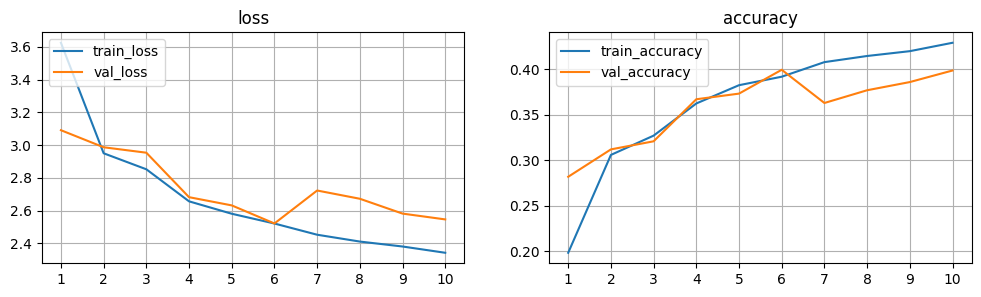

In [102]:
train(model15, 'resnet-15', weight_decay=5e-4)

In [103]:
utils.evaluate_model(model15, test_dl, loss_fn=nn.CrossEntropyLoss(), metrics=[utils.metric_accuracy])

{'loss': 2.4939706439971925, 'accuracy': 0.4035}

In [113]:
class ResNet18Transfer2(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrained = resnet18(weights=ResNet18_Weights.DEFAULT).to(utils.device)
        self.pretrained.fc = nn.Linear(512, 200)

    def forward(self, x):
        x = self.pretrained(x)
        return x
        
model16 = ResNet18Transfer2().to(utils.device)
utils.print_params(model16)

pretrained.conv1                 weight              ✅ 9.41 k     [64, 3, 7, 7]
pretrained.bn1                   weight              ✅ 64.0       [64]
                                 bias                ✅ 64.0       [64]
                                 running_mean        ⛔ 64.0       [64]
                                 running_var         ⛔ 64.0       [64]
                                 num_batches_tracked ⛔ 1.00       []
pretrained.layer1.0.conv1        weight              ✅ 36.9 k     [64, 64, 3, 3]
pretrained.layer1.0.bn1          weight              ✅ 64.0       [64]
                                 bias                ✅ 64.0       [64]
                                 running_mean        ⛔ 64.0       [64]
                                 running_var         ⛔ 64.0       [64]
                                 num_batches_tracked ⛔ 1.00       []
pretrained.layer1.0.conv2        weight              ✅ 36.9 k     [64, 64, 3, 3]
pretrained.layer1.0.bn2          weight             

100%|██████████| 157/157 [00:01<00:00, 92.98it/s] 


Epoch 1/1000: train_loss=1.8821, train_accuracy=0.5255, val_loss=2.1174, val_accuracy=0.4833
Saving params from epoch 1. Best loss: 2.1174


100%|██████████| 157/157 [00:02<00:00, 73.16it/s]


Epoch 2/1000: train_loss=1.8693, train_accuracy=0.5291, val_loss=2.1187, val_accuracy=0.4837


100%|██████████| 157/157 [00:01<00:00, 93.29it/s] 


Epoch 3/1000: train_loss=1.8552, train_accuracy=0.5314, val_loss=2.1064, val_accuracy=0.4840
Saving params from epoch 3. Best loss: 2.1064


100%|██████████| 157/157 [00:02<00:00, 77.26it/s]


Epoch 4/1000: train_loss=1.8455, train_accuracy=0.5337, val_loss=2.1094, val_accuracy=0.4849


100%|██████████| 157/157 [00:02<00:00, 72.34it/s]


Epoch 5/1000: train_loss=1.8460, train_accuracy=0.5346, val_loss=2.1108, val_accuracy=0.4844


100%|██████████| 157/157 [00:02<00:00, 72.79it/s]


Epoch 6/1000: train_loss=1.8354, train_accuracy=0.5363, val_loss=2.1142, val_accuracy=0.4810


100%|██████████| 157/157 [00:01<00:00, 87.48it/s]


Epoch 7/1000: train_loss=1.8265, train_accuracy=0.5382, val_loss=2.1090, val_accuracy=0.4815
Loading model params from epoch 3
{'loss': 2.129713843536377, 'accuracy': 0.4857}


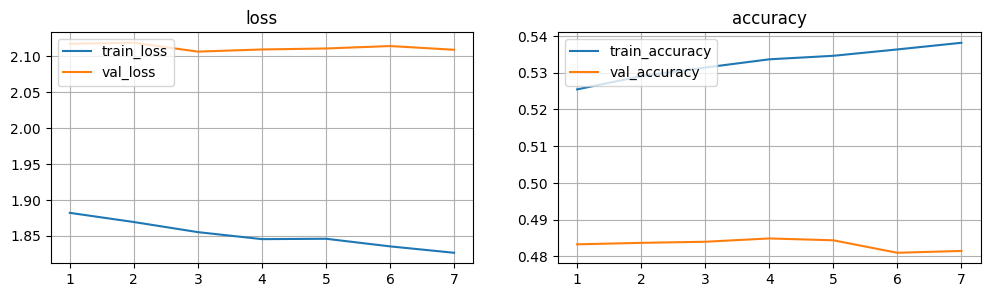

In [118]:
train(model16, 'resnet-16', lr=1e-5, weight_decay=5e-4)

In [119]:
utils.evaluate_model(model16, test_dl, loss_fn=nn.CrossEntropyLoss(), metrics=[utils.metric_accuracy])

{'loss': 2.129713843536377, 'accuracy': 0.4857}

In [124]:
class ResNet50Transfer(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrained = resnet50(weights=ResNet50_Weights.DEFAULT).to(utils.device)
        self.pretrained.fc = nn.Linear(2048, 200)

    def forward(self, x):
        x = self.pretrained(x)
        return x
        
model17 = ResNet50Transfer().to(utils.device)
utils.print_params(model17)

pretrained.conv1                 weight              ✅ 9.41 k     [64, 3, 7, 7]
pretrained.bn1                   weight              ✅ 64.0       [64]
                                 bias                ✅ 64.0       [64]
                                 running_mean        ⛔ 64.0       [64]
                                 running_var         ⛔ 64.0       [64]
                                 num_batches_tracked ⛔ 1.00       []
pretrained.layer1.0.conv1        weight              ✅ 4.10 k     [64, 64, 1, 1]
pretrained.layer1.0.bn1          weight              ✅ 64.0       [64]
                                 bias                ✅ 64.0       [64]
                                 running_mean        ⛔ 64.0       [64]
                                 running_var         ⛔ 64.0       [64]
                                 num_batches_tracked ⛔ 1.00       []
pretrained.layer1.0.conv2        weight              ✅ 36.9 k     [64, 64, 3, 3]
pretrained.layer1.0.bn2          weight             

100%|██████████| 157/157 [00:04<00:00, 36.38it/s]


Epoch 1/1000: train_loss=3.2880, train_accuracy=0.2525, val_loss=2.9226, val_accuracy=0.3217
Saving params from epoch 1. Best loss: 2.9226


100%|██████████| 157/157 [00:04<00:00, 38.28it/s]


Epoch 2/1000: train_loss=2.8984, train_accuracy=0.3182, val_loss=2.8226, val_accuracy=0.3369
Saving params from epoch 2. Best loss: 2.8226


100%|██████████| 157/157 [00:04<00:00, 37.90it/s]


Epoch 3/1000: train_loss=2.8039, train_accuracy=0.3364, val_loss=2.6820, val_accuracy=0.3601
Saving params from epoch 3. Best loss: 2.6820


100%|██████████| 157/157 [00:04<00:00, 32.65it/s]


Epoch 4/1000: train_loss=2.7526, train_accuracy=0.3455, val_loss=2.6063, val_accuracy=0.3718
Saving params from epoch 4. Best loss: 2.6063


100%|██████████| 157/157 [00:04<00:00, 38.93it/s]


Epoch 5/1000: train_loss=2.7134, train_accuracy=0.3550, val_loss=2.5901, val_accuracy=0.3810
Saving params from epoch 5. Best loss: 2.5901


100%|██████████| 157/157 [00:04<00:00, 37.99it/s]


Epoch 6/1000: train_loss=2.6809, train_accuracy=0.3601, val_loss=2.5580, val_accuracy=0.3786
Saving params from epoch 6. Best loss: 2.5580


100%|██████████| 157/157 [00:04<00:00, 37.96it/s]


Epoch 7/1000: train_loss=2.6509, train_accuracy=0.3642, val_loss=2.5555, val_accuracy=0.3830
Saving params from epoch 7. Best loss: 2.5555


100%|██████████| 157/157 [00:04<00:00, 38.59it/s]


Epoch 8/1000: train_loss=2.6385, train_accuracy=0.3671, val_loss=2.5385, val_accuracy=0.3855
Saving params from epoch 8. Best loss: 2.5385


100%|██████████| 157/157 [00:04<00:00, 37.91it/s]


Epoch 9/1000: train_loss=2.6143, train_accuracy=0.3720, val_loss=2.5490, val_accuracy=0.3845


100%|██████████| 157/157 [00:05<00:00, 30.30it/s]


Epoch 10/1000: train_loss=2.5980, train_accuracy=0.3768, val_loss=2.5340, val_accuracy=0.3855
Saving params from epoch 10. Best loss: 2.5340


100%|██████████| 157/157 [00:04<00:00, 38.58it/s]


Epoch 11/1000: train_loss=2.5799, train_accuracy=0.3805, val_loss=2.5321, val_accuracy=0.3926
Saving params from epoch 11. Best loss: 2.5321


100%|██████████| 157/157 [00:04<00:00, 38.74it/s]


Epoch 12/1000: train_loss=2.5624, train_accuracy=0.3850, val_loss=2.5223, val_accuracy=0.3904
Saving params from epoch 12. Best loss: 2.5223


100%|██████████| 157/157 [00:04<00:00, 38.52it/s]


Epoch 13/1000: train_loss=2.5538, train_accuracy=0.3861, val_loss=2.6116, val_accuracy=0.3759


100%|██████████| 157/157 [00:04<00:00, 38.54it/s]


Epoch 14/1000: train_loss=2.5430, train_accuracy=0.3901, val_loss=2.4151, val_accuracy=0.4149
Saving params from epoch 14. Best loss: 2.4151


100%|██████████| 157/157 [00:06<00:00, 25.89it/s]


Epoch 15/1000: train_loss=2.5320, train_accuracy=0.3900, val_loss=2.5547, val_accuracy=0.3883


100%|██████████| 157/157 [00:04<00:00, 38.53it/s]


Epoch 16/1000: train_loss=2.5225, train_accuracy=0.3924, val_loss=2.5166, val_accuracy=0.3910


100%|██████████| 157/157 [00:04<00:00, 38.49it/s]


Epoch 17/1000: train_loss=2.5171, train_accuracy=0.3943, val_loss=2.4954, val_accuracy=0.3994


100%|██████████| 157/157 [00:04<00:00, 38.35it/s]

Epoch 18/1000: train_loss=2.5059, train_accuracy=0.3967, val_loss=2.4420, val_accuracy=0.4085
Loading model params from epoch 14


{'loss': 2.4289841850280762, 'accuracy': 0.4105}


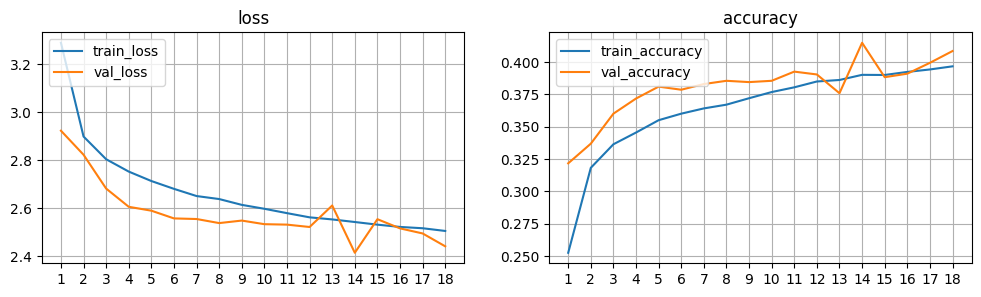

In [125]:
train(model17, 'resnet-17', weight_decay=5e-4)

In [126]:
utils.evaluate_model(model17, test_dl, loss_fn=nn.CrossEntropyLoss(), metrics=[utils.metric_accuracy])

{'loss': 2.4289841850280762, 'accuracy': 0.4105}